In [537]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import timeit
from arch.bootstrap import CircularBlockBootstrap, optimal_block_length
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log
from scipy.stats import boxcox
from os import getenv, path
from pathlib import Path

In [538]:
# dynamic to decide logon info 
# then login to wrds
def pgpass_dir():
    if sys.platform.startswith('win'):
        os_path = getenv('LOCALAPPDATA')
        file_path = os_path+'\postgresql\pgpass.conf'
        print (file_path)
    elif sys.platform.startswith('darwin'):
        #my path is clear thus I use my own
        #* can be replaced by any laptop name
        if path.exists('/Users/argool/.pgpass'):
            file_path = '/Users/argool/.pgpass'
        else:
            dir_path = os.path.dirname('/Users/')
            keyword = '.pgpass'
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    if keyword in file:
                        file_path = root+'/'+str(file)
    return file_path

In [539]:
file_path = pgpass_dir()
#read login info and pass connection parameters
with open(file_path,'r') as f:
    output = f.read()
    
    login_id = output.split(":")[3]
    crsp_db = wrds.Connection(wrds_username=login_id)

Loading library list...
Done


In [540]:
#combine login into one function
#in order to keep timeout away
#issue : too many connections to server 
# not in use
def re_conn_wrds():
    file_path = pgpass_dir()
    #read login info and pass connection parameters
    with open(file_path,'r') as f:
        output = f.read()
        login_id = output.split(":")[3]
        crsp_db = wrds.Connection(wrds_username=login_id)

In [541]:
#retrieved cooresponding permno 
#criterion : the latest valid date
def data_generator(num=3, ticker_name=tuple(['GLD','SPY','TLT'])):
    ticker_list = {'tickers': tuple(ticker_name)}
    permno_list_init = crsp_db.raw_sql('SELECT a.permno FROM crsp.stocknames a, (SELECT distinct(max(nameenddt)) as date_time FROM crsp.stocknames WHERE ticker in %(tickers)s group by ticker) as b WHERE a.ticker in %(tickers)s and a.nameenddt = b.date_time group by a.permno', params=ticker_list)
    #generate tuple for permno
    permno_list_tuple = tuple(permno_list_init.permno.astype(str).values.tolist())
    permno_list = {'permno': permno_list_tuple}
    #generate data
    final_data = crsp_db.raw_sql('select distinct b.ticker, a.date, a.prc, a.ret from crspm.dsf a, crsp.stocknames b, \
    (select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) temp) as c \
where a.permno in %(permno)s and a.permno = b.permno and a.date >= c.start_time order by 1,2,3 asc', params=permno_list,date_cols=['date'])
    return final_data

In [552]:
#generate dataframe and pickle file
def input_ticker():
    number_stock = int(input("Please enter your number of stocks, e.g 3,4,5: ").strip())
    ticker_name = []
    [ticker_name.append(input("Please enter one ticker each time, e.g spy, tlt, gld: ").strip().upper()) for i in range(number_stock)]
    final_data = data_generator(number_stock,ticker_name)
    final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
    final_data_pivot.to_pickle('dummy_data.pkl')
    return final_data_pivot

In [553]:
input_ticker()

ticker             GLD                   SPY                   TLT          
                   prc       ret         prc       ret         prc       ret
date                                                                        
2004-11-18   44.380001       NaN  118.739998  0.001349   88.970001  0.003044
2004-11-19   44.779999  0.009013  117.419998 -0.011117   88.260002 -0.007980
2004-11-22   44.950001  0.003796  117.980003  0.004769   88.720001  0.005212
2004-11-23   44.750000 -0.004449  118.160004  0.001526   88.830002  0.001240
2004-11-24   45.049999  0.006704  118.440002  0.002370   88.830002  0.000000
...                ...       ...         ...       ...         ...       ...
2020-12-24  176.350006  0.003985  369.000000  0.003890  157.289993  0.003957
2020-12-28  175.710007 -0.003629  372.170013  0.008591  157.360001  0.000445
2020-12-29  176.350006  0.003642  371.459991 -0.001908  157.160004 -0.001271
2020-12-30  177.699997  0.007655  371.989990  0.001427  157.500000  0.002163
2020-12-31  178.360001  0.003714  373.880005  0.005081  157.729996  0.001460

[4058 rows x 6 columns]

In [555]:
with open('dummy_data.pkl', 'rb') as f: dummy_data = pickle.load(f)

In [556]:
dummy_data

ticker             GLD                   SPY                   TLT          
                   prc       ret         prc       ret         prc       ret
date                                                                        
2004-11-18   44.380001       NaN  118.739998  0.001349   88.970001  0.003044
2004-11-19   44.779999  0.009013  117.419998 -0.011117   88.260002 -0.007980
2004-11-22   44.950001  0.003796  117.980003  0.004769   88.720001  0.005212
2004-11-23   44.750000 -0.004449  118.160004  0.001526   88.830002  0.001240
2004-11-24   45.049999  0.006704  118.440002  0.002370   88.830002  0.000000
...                ...       ...         ...       ...         ...       ...
2020-12-24  176.350006  0.003985  369.000000  0.003890  157.289993  0.003957
2020-12-28  175.710007 -0.003629  372.170013  0.008591  157.360001  0.000445
2020-12-29  176.350006  0.003642  371.459991 -0.001908  157.160004 -0.001271
2020-12-30  177.699997  0.007655  371.989990  0.001427  157.500000  0.002163
2020-12-31  178.360001  0.003714  373.880005  0.005081  157.729996  0.001460

[4058 rows x 6 columns]

In [367]:
def sim_returns(data, block_size = 20, total_sim = 10, random_seed = 1):
    ret_index = [x for x, y in enumerate(d.columns) if y[1] == 'ret']
    ret_sim = data.iloc[:,ret_index].to_numpy()
    rs = np.random.RandomState(random_seed)
    ret_sim_mod = CircularBlockBootstrap(block_size, ret_sim, random_state = rs)
    col = ret_sim.shape[1]
    sim = np.zeros((total_sim,len(data), col))
    count = 0
    for y in ret_sim_mod.bootstrap(total_sim):
        sim[count,:,:] = y[0][0]
        count +=1
    return sim

In [238]:
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)
d = d.iloc[:,[1,5,9]]
d.iloc[0] = [1,1,1]
portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
initial_money = 1000000
rebalance_days = 4500
threshold = .05

In [287]:
d

ticker             SPY                                  TLT            \
metric             prc       ret      retx retd         prc       ret   
date                                                                    
2004-11-19  117.419998  0.988883  0.988883  0.0   88.260002  0.992020   
2004-11-22  117.980003  1.004769  1.004769  0.0   88.720001  1.005212   
2004-11-23  118.160004  1.001526  1.001526  0.0   88.830002  1.001240   
2004-11-24  118.440002  1.002370  1.002370  0.0   88.830002  1.000000   
2004-11-26  118.339996  0.999156  0.999156  0.0   88.250000  0.993471   
...                ...       ...       ...  ...         ...       ...   
2020-11-23  357.459991  1.005994  1.005994  0.0  160.770004  0.995418   
2020-11-24  363.220001  1.016114  1.016114  0.0  159.169998  0.990048   
2020-11-25  362.660004  0.998458  0.998458  0.0  158.679993  0.996921   
2020-11-27  363.670013  1.002785  1.002785  0.0  160.220001  1.009705   
2020-11-30  362.059998  0.995573  0.995573  0.0  160.020004  0.998752   

ticker                            GLD                           
metric          retx retd         prc       ret      retx retd  
date                                                            
2004-11-19  0.992020  0.0   44.779999  1.009013  1.009013  0.0  
2004-11-22  1.005212  0.0   44.950001  1.003796  1.003796  0.0  
2004-11-23  1.001240  0.0   44.750000  0.995551  0.995551  0.0  
2004-11-24  1.000000  0.0   45.049999  1.006704  1.006704  0.0  
2004-11-26  0.993471  0.0   45.290001  1.005327  1.005327  0.0  
...              ...  ...         ...       ...       ...  ...  
2020-11-23  0.995418  0.0  172.229996  0.980306  0.980306  0.0  
2020-11-24  0.990048  0.0  169.589996  0.984672  0.984672  0.0  
2020-11-25  0.996921  0.0  169.509995  0.999528  0.999528  0.0  
2020-11-27  1.009705  0.0  167.789993  0.989853  0.989853  0.0  
2020-11-30  0.998752  0.0  166.669998  0.993325  0.993325  0.0  

[4035 rows x 12 columns]

In [247]:
#Ning's rewrite
total_sim = 100
col = 2
bootstrap = sim_returns(d,block_size = 20, total_sim = total_sim, random_seed = 1)
arr_value = np.zeros((total_sim,len(d), col))
counter = 0
for x in bootstrap:
    x[0] = [1,1,1]
    portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
    initial_money = 1000000
    rebalance_days = 1
    threshold = 10


    arr_data = x

    ls_tickers = []
    temp_tickers = list([y[0] for x, y in enumerate(arr_data_columns)])
    for i in temp_tickers:
        if i not in ls_tickers:
            ls_tickers.append(i)

    arr_port_det = np.zeros([d.shape[0], 9]) #Need to change back to data
    arr_port_sum = np.zeros([d.shape[0], 2]) #Need to change back to data
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
    cum_ret={}
    for k in range(len(ls_ret_index)):
        cum_ret[k]=arr_data[:,ls_ret_index[k]].cumprod()

    cum_ret_1= pd.DataFrame(data=cum_ret)
    cum_ret_1.columns = ls_tickers
    cum_ret_1.columns = [str(col) + '_cum_ret' for col in cum_ret_1.columns]
    num_rows, num_cols = arr_data.shape
    ls_cum_ret_index = [x for x, y in enumerate(cum_ret_1)]
    ls_cum_ret_index=[x+num_cols for x in ls_cum_ret_index]
    cum_ret_2 = np.array(cum_ret_1)

    #Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
    #needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
    #and this will be used to reset the cumulative returns.

    cum_ret_tracking = np.array(cum_ret_1.iloc[1])

    cum_ret_tracking[:]=1

    trading_day_counter=1
    count = 0
    initial_arr_asset_val = initial_money*arr_portfolio_weights

    for row in cum_ret_2:
        tradeflag = 0
        arr_rebal = np.zeros(len(ls_tickers))
        arr_latest_ret = row

        cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
        total_value = np.sum(cur_asset_val)
        arr_actual_weights = cur_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)

        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:

            tradeflag = 1
            cum_ret_tracking = arr_latest_ret

            arr_new_port_det = np.array([], dtype='f8')
          
            cur_asset_val = total_value*arr_portfolio_weights
      
            initial_arr_asset_val = cur_asset_val
            trading_day_counter=1
        else:
            trading_day_counter += 1    

        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
        #total_value

        arr_new_port_det = np.array([], dtype='f8')
        ls_new_port_det = []
        for i in range(len(ls_tickers)):

            ls_new_port_det = ls_new_port_det + [row[ls_ret_index[i]], arr_actual_weights[i], cur_asset_val[i]]

        arr_port_det[count] = ls_new_port_det

        #arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
        arr_new_port_sum = [total_value]

        arr_port_sum[count] = arr_new_port_sum
        tradeflag = 0
        count += 1
    arr_value[counter] = arr_port_sum
    counter +=1
    

In [248]:
arr_value

array([[[1000000.        , 1000000.        ],
        [ 987927.49494314,  987927.49494314],
        [ 998243.42121614,  998243.42121614],
        ...,
        [2215169.96833631, 2215169.96833631],
        [2209869.55086891, 2209869.55086891],
        [2210728.63896946, 2210728.63896946]],

       [[1000000.        , 1000000.        ],
        [1006790.29081948, 1006790.29081948],
        [1007896.36866594, 1007896.36866594],
        ...,
        [5637194.26137184, 5637194.26137184],
        [5638294.77574348, 5638294.77574348],
        [5646151.39162742, 5646151.39162742]],

       [[1000000.        , 1000000.        ],
        [1002721.45556519, 1002721.45556519],
        [1003926.85586218, 1003926.85586218],
        ...,
        [4324647.64657581, 4324647.64657581],
        [4288511.69186387, 4288511.69186387],
        [4438208.04618975, 4438208.04618975]],

       ...,

       [[1000000.        , 1000000.        ],
        [ 994478.09220292,  994478.09220292],
        [1001529.62328

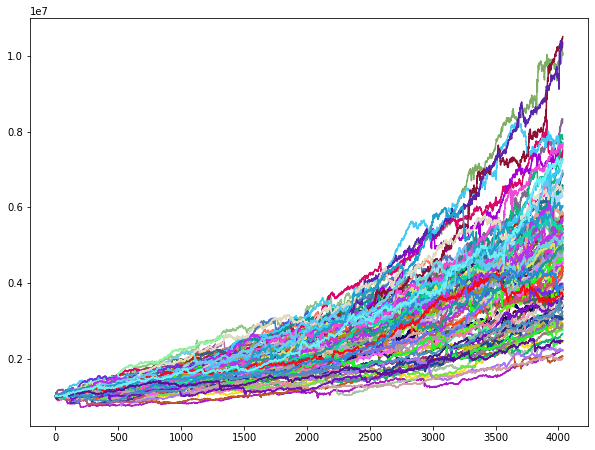

In [249]:
import random

b = list(range(4035))
a = [arr_value[i][:,0] for i in range(total_sim)]

rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

In [243]:

a = [arr_value[i][:,0] for i in range(total_sim)]
a

[array([1000000.        ,  987927.49494314,  998396.52904796, ...,
        2182831.62527276, 2177606.98962161, 2178419.56521579]),
 array([1000000.        , 1006790.29081948, 1007900.52671336, ...,
        5593658.43829496, 5595986.64511758, 5603394.5594043 ]),
 array([1000000.        , 1002721.45556519, 1003927.99309993, ...,
        4252052.47325222, 4216523.1103623 , 4363904.32570543]),
 array([1000000.        , 1000778.48120127,  998816.39306567, ...,
        3005903.26791685, 3003750.01563653, 3005921.78807413]),
 array([1000000.        ,  999192.32399552, 1003542.90086336, ...,
        5202241.07208625, 5201623.59234392, 5208272.90351613]),
 array([1000000.        , 1003642.63005322, 1000249.43981076, ...,
        4975915.79804171, 4961167.49948514, 4923584.55108385]),
 array([1000000.        , 1001518.92381291, 1011848.39197443, ...,
        5828403.45560697, 5804609.26919975, 5750466.96207652]),
 array([1000000.        , 1001447.45905563, 1002863.8375297 , ...,
        5369761.

In [208]:
arr_port_det = np.zeros([d.shape[0], 9]) #Need to change back to data
arr_port_sum = np.zeros([d.shape[0], 2]) #Need to change back to data
arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
cum_ret={}
for k in range(len(ls_ret_index)):
    cum_ret[k]=d[:,ls_ret_index[k]].cumprod()

cum_ret_1= pd.DataFrame(data=cum_ret)
cum_ret_1.columns = ls_tickers
cum_ret_1.columns = [str(col) + '_cum_ret' for col in cum_ret_1.columns]
num_rows, num_cols = arr_data.shape
ls_cum_ret_index = [x for x, y in enumerate(cum_ret_1)]
ls_cum_ret_index=[x+num_cols for x in ls_cum_ret_index]
cum_ret_2 = np.array(cum_ret_1)

#Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
#needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
#and this will be used to reset the cumulative returns.

cum_ret_tracking = np.array(cum_ret_1.iloc[1])

cum_ret_tracking[:]=1

trading_day_counter=1
count = 0
initial_arr_asset_val = initial_money*arr_portfolio_weights

for row in cum_ret_2:
    tradeflag = 0
    arr_rebal = np.zeros(len(ls_tickers))
    arr_latest_ret = row

    cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
    total_value = np.sum(cur_asset_val)
    arr_actual_weights = cur_asset_val/total_value
    dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)

    if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:

        tradeflag = 1
        cum_ret_tracking = arr_latest_ret

        arr_new_port_det = np.array([], dtype='f8')
        print(trading_day_counter)
        cur_asset_val = total_value*arr_portfolio_weights
        print(cur_asset_val)
        initial_arr_asset_val = cur_asset_val
        trading_day_counter=1
    else:
        trading_day_counter += 1    

    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    #total_value

    arr_new_port_det = np.array([], dtype='f8')
    ls_new_port_det = []
    for i in range(len(ls_tickers)):

        ls_new_port_det = ls_new_port_det + [row[ls_ret_index[i]], arr_actual_weights[i], cur_asset_val[i]]

    arr_port_det[count] = ls_new_port_det

    #arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
    arr_new_port_sum = [total_value]

    arr_port_sum[count] = arr_new_port_sum
    tradeflag = 0
    count += 1

4
[497919.74442459 398335.79553967  99583.94888492]
3
[485174.80699814 388139.84559851  97034.96139963]
8
[454195.45612458 363356.36489967  90839.09122492]
48
[481884.45383762 385507.5630701   96376.89076752]
27
[474551.64579325 379641.3166346   94910.32915865]
1
[461244.76284888 368995.81027911  92248.95256978]
1
[462747.99415227 370198.39532181  92549.59883045]
2
[422700.4211579  338160.33692632  84540.08423158]
1
[435656.30003989 348525.04003191  87131.26000798]
1
[422608.27210384 338086.61768307  84521.65442077]
1
[423317.57260196 338654.05808157  84663.51452039]
3
[410522.11964095 328417.69571276  82104.42392819]
2
[408802.55382532 327042.04306026  81760.51076506]
9
[404844.05172486 323875.24137989  80968.81034497]
8
[406472.1756398  325177.74051184  81294.43512796]
43
[406735.24528016 325388.19622412  81347.04905603]
19
[412432.27979971 329945.82383976  82486.45595994]
2
[411448.43474194 329158.74779356  82289.68694839]
2
[418613.88550726 334891.10840581  83722.77710145]
6
[40472

In [178]:
 df_portfolio_sum = pd.DataFrame(arr_port_sum, index = d.index)

In [106]:
 df_portfolio_detail = pd.DataFrame(arr_port_det, index = d.index)

In [162]:
df_portfolio_detail.head(50)

Empty DataFrame
Columns: [(SPY, price), (SPY, return), (SPY, weight), (SPY, shares), (SPY, value), (TLT, price), (TLT, return), (TLT, weight), (TLT, shares), (TLT, value), (GLD, price), (GLD, return), (GLD, weight), (GLD, shares), (GLD, value)]
Index: []

In [98]:
cum_ret_1

,SPY_cum_ret,TLT_cum_ret,GLD_cum_ret
0,0.988883,0.992020,1.009013
1,0.993600,0.997190,1.012844
2,0.995115,0.998426,1.008337
3,0.997474,0.998426,1.015097
4,0.996631,0.991907,1.020505
...,...,...,...
4030,4.146188,3.067622,3.880802
4031,4.212999,3.037092,3.821316
4032,4.206503,3.027743,3.819513
4033,4.218218,3.057127,3.780757
